# 3D Geological Modeling and Analysis

This notebook implements a comprehensive pipeline for 3D geological modeling and analysis using Jupyter notebooks. The project simulates and analyzes geological structures, specifically focusing on the slicing of rock formations by discontinuities and the subsequent volumetric and spatial analysis of the resulting segments.

## Project Overview

The pipeline leverages various libraries for 3D mesh manipulation, numerical computation, and data handling to:
1. Read geological discontinuity data from Excel files
2. Create 3D stone models and define discontinuity planes
3. Slice the stone model into segments using geological discontinuities
4. Calculate volumes and geometric properties of segments
5. Visualize results in 3D with color-coding
6. Export processed data for further analysis

## Import Required Libraries

Import all necessary libraries for 3D mesh processing, numerical operations, data handling, and visualization.

In [1]:
import numpy as np
import trimesh
import pandas as pd
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Trimesh version: {trimesh.__version__}")
print(f"Pandas version: {pd.__version__}")

Libraries imported successfully!
NumPy version: 2.3.3
Trimesh version: 4.8.2
Pandas version: 2.3.2


## Helper Functions

Define utility functions for geological calculations and geometric operations.

In [2]:
def calculate_normal_vector(dip, dip_direction):
    """
    Convert geological dip and dip direction to 3D normal vector.
    
    Parameters:
    - dip: angle of dip in degrees
    - dip_direction: direction of dip in degrees
    
    Returns:
    - numpy array: 3D normal vector
    """
    dip_radians = np.radians(dip)
    dip_direction_radians = np.radians(dip_direction)
    
    nx = np.sin(dip_radians) * np.sin(dip_direction_radians)
    ny = -np.sin(dip_radians) * np.cos(dip_direction_radians)
    nz = np.cos(dip_radians)
    
    return np.array([nx, ny, nz])

def line_plane_intersection(p1, p2, p0, n):
    """
    Calculate intersection point of a line segment with a plane.
    
    Parameters:
    - p1, p2: endpoints of line segment
    - p0: point on plane
    - n: normal vector of plane
    
    Returns:
    - intersection point or None if no intersection
    """
    d = p2 - p1
    denom = np.dot(n, d)
    
    if abs(denom) < 1e-6:  # Line is parallel to plane
        return None
    
    t = np.dot(n, p0 - p1) / denom
    
    if 0 <= t <= 1:  # Intersection is within line segment
        return p1 + t * d
    
    return None

def calculate_hull_volume(points):
    """
    Calculate volume of convex hull from points.
    
    Parameters:
    - points: array of 3D points
    
    Returns:
    - volume: float
    """
    if len(points) < 4:  # Need at least 4 points for 3D hull
        return 0
    
    try:
        hull = ConvexHull(points)
        return hull.volume
    except:
        return 0

def read_excel(file_path):
    """Read Excel file and return DataFrame."""
    return pd.read_excel(file_path)

print("Helper functions defined successfully!")

Helper functions defined successfully!


## Stone Class Definition

Define the main Stone class for geological modeling and analysis.

In [3]:
class Stone:
    def __init__(self, width, length, height):
        """
        Initialize a geological stone block.
        
        Parameters:
        - width: stone width in meters
        - length: stone length in meters  
        - height: stone height in meters
        """
        self.width = width
        self.length = length
        self.height = height
        self.discontinuities = []
        self.mesh = self.create_stone_mesh()
        
        # Define stone vertices for manual slicing
        self.vertices = np.array([
            [0, 0, 0], [self.width, 0, 0], [self.width, self.length, 0], [0, self.length, 0],
            [0, 0, self.height], [self.width, 0, self.height], 
            [self.width, self.length, self.height], [0, self.length, self.height]
        ])
        
        print(f"Stone initialized: {width}m x {length}m x {height}m")
    
    def create_stone_mesh(self):
        """Create a trimesh mesh for the stone."""
        # Define vertices for a box
        vertices = np.array([
            [0, 0, 0], [self.width, 0, 0], [self.width, self.length, 0], [0, self.length, 0],
            [0, 0, self.height], [self.width, 0, self.height], 
            [self.width, self.length, self.height], [0, self.length, self.height]
        ])
        
        # Define faces (convert quads to triangles)
        faces = np.array([
            [0, 1, 2, 3],  # Bottom face
            [4, 5, 6, 7],  # Top face
            [0, 1, 5, 4],  # Front face
            [1, 2, 6, 5],  # Right face
            [2, 3, 7, 6],  # Back face
            [3, 0, 4, 7]   # Left face
        ])
        
        # Convert quads to triangles
        faces_tri = []
        for face in faces:
            faces_tri.append([face[0], face[1], face[2]])
            faces_tri.append([face[0], face[2], face[3]])
        
        return trimesh.Trimesh(vertices=vertices, faces=np.array(faces_tri))
    
    def add_discontinuity(self, dip, dip_direction, x, y, z):
        """Add a geological discontinuity plane."""
        normal_vector = calculate_normal_vector(dip, dip_direction)
        self.discontinuities.append((normal_vector, (x, y, z)))
        print(f"Added discontinuity: dip={dip}°, dip_direction={dip_direction}°, point=({x},{y},{z})")
    
    def read_discontinuities_from_excel(self, file_path):
        """Read discontinuities from Excel file."""
        try:
            df = pd.read_excel(file_path)
            print(f"Reading discontinuities from: {file_path}")
            print(f"Data shape: {df.shape}")
            print("\\nData preview:")
            print(df.head())
            
            for _, row in df.iterrows():
                self.add_discontinuity(row['dip'], row['dip direction'], row['x'], row['y'], row['z'])
            
            print(f"\\nTotal discontinuities loaded: {len(self.discontinuities)}")
        except Exception as e:
            print(f"Error reading Excel file: {e}")
    
    def get_edges(self, vertices):
        """Get edges of a convex hull."""
        try:
            hull = ConvexHull(vertices)
            edges = set()
            for simplex in hull.simplices:
                for i in range(len(simplex)):
                    for j in range(i + 1, len(simplex)):
                        edge = tuple(sorted([simplex[i], simplex[j]]))
                        edges.add(edge)
            return list(edges)
        except:
            return []

print("Stone class defined successfully!")

Stone class defined successfully!


## Stone Class Methods - Slicing and Analysis

Add methods for slicing the stone with discontinuities and calculating volumes.

In [5]:
# Add slicing methods to Stone class
def slice_with_discontinuities(self):
    """Slice the stone with all discontinuities using iterative vertex-based method."""
    segments = [self.vertices]  # Start with initial stone vertices
    
    print(f"Starting slicing with {len(self.discontinuities)} discontinuities...")
    
    for i, (normal_vector, point) in enumerate(self.discontinuities):
        print(f"Processing discontinuity {i+1}/{len(self.discontinuities)}")
        new_segments = []
        
        for segment in segments:
            above = []
            below = []
            intersections = []
            
            # Find intersections with the plane for each edge
            edges = self.get_edges(segment)
            for edge in edges:
                if edge[0] < len(segment) and edge[1] < len(segment):
                    intersection = line_plane_intersection(
                        segment[edge[0]], segment[edge[1]], 
                        np.array(point), normal_vector
                    )
                    if intersection is not None:
                        intersections.append(intersection)
            
            # Remove duplicate intersections
            if len(intersections) > 0:
                intersections = np.array(intersections)
                # Remove duplicates with tolerance
                unique_intersections = []
                for point_int in intersections:
                    is_duplicate = False
                    for existing in unique_intersections:
                        if np.linalg.norm(point_int - existing) < 1e-6:
                            is_duplicate = True
                            break
                    if not is_duplicate:
                        unique_intersections.append(point_int)
                intersections = unique_intersections
            
            # Classify vertices as above or below the plane
            for vertex in segment:
                if np.dot(normal_vector, vertex - np.array(point)) > 1e-6:
                    above.append(vertex)
                else:
                    below.append(vertex)
            
            # Create new segments
            if len(above) > 0 and len(below) > 0 and len(intersections) >= 3:
                # We have a proper split
                if len(above) >= 3:
                    new_segments.append(np.vstack([above, intersections]))
                if len(below) >= 3:
                    new_segments.append(np.vstack([below, intersections]))
            else:
                # No split or insufficient points
                new_segments.append(segment)
        
        segments = [seg for seg in new_segments if len(seg) >= 4]  # Keep only valid segments
    
    print(f"Slicing complete. Generated {len(segments)} segments.")
    return segments

def slice_mesh(self):
    """Slice the trimesh mesh using trimesh built-in methods."""
    sliced_mesh = self.mesh.copy()
    
    for normal_vector, point in self.discontinuities:
        try:
            sliced_mesh = sliced_mesh.slice_plane(
                plane_normal=normal_vector, 
                plane_origin=point
            )
        except:
            print("Warning: Could not slice with one discontinuity")
            continue
    
    return sliced_mesh

def calculate_volumes(self):
    """Calculate volumes of all segments."""
    segments = self.slice_with_discontinuities()
    volumes = []
    
    for i, segment in enumerate(segments):
        volume = calculate_hull_volume(segment)
        volumes.append(volume)
        print(f"Segment {i+1}: {volume:.2f} cubic units")
    
    return volumes

# Add methods to Stone class
Stone.slice_with_discontinuities = slice_with_discontinuities
Stone.slice_mesh = slice_mesh
Stone.calculate_volumes = calculate_volumes

print("Slicing methods added to Stone class!")

Slicing methods added to Stone class!


## Stone Class Methods - Visualization and Export

Add visualization and export methods to the Stone class.

In [6]:
def visualize(self):
    """Visualize the stone and its segments using matplotlib."""
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Get segments
    segments = self.slice_with_discontinuities()
    volumes = []
    
    # Plot each segment with volume-based coloring
    for i, segment in enumerate(segments):
        if len(segment) >= 4:
            try:
                hull = ConvexHull(segment)
                hull_faces = [[segment[vertex] for vertex in face] for face in hull.simplices]
                volume = calculate_hull_volume(segment)
                volumes.append(volume)
                
                # Color based on volume
                if volume < 20:
                    color = 'red'
                    alpha = 0.7
                elif 20 <= volume <= 25:
                    color = 'yellow'
                    alpha = 0.8
                else:
                    color = 'green'
                    alpha = 0.9
                
                poly3d = Poly3DCollection(hull_faces, facecolors=color, 
                                        linewidths=1, edgecolors='black', alpha=alpha)
                ax.add_collection3d(poly3d)
                
                # Add volume label
                center = np.mean(segment, axis=0)
                ax.text(center[0], center[1], center[2], f'{volume:.1f}', 
                       fontsize=8, ha='center')
                
            except Exception as e:
                print(f"Warning: Could not visualize segment {i}: {e}")
    
    # Set plot properties
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')
    ax.set_title(f'3D Stone Segmentation\\n{len(segments)} segments, Total volume: {sum(volumes):.2f}')
    
    # Set equal aspect ratio
    max_range = max(self.width, self.length, self.height)
    ax.set_xlim([0, max_range])
    ax.set_ylim([0, max_range])
    ax.set_zlim([0, max_range])
    
    # Add legend
    import matplotlib.patches as mpatches
    red_patch = mpatches.Patch(color='red', label='Volume < 20')
    yellow_patch = mpatches.Patch(color='yellow', label='20 ≤ Volume ≤ 25')
    green_patch = mpatches.Patch(color='green', label='Volume > 25')
    ax.legend(handles=[red_patch, yellow_patch, green_patch])
    
    plt.tight_layout()
    plt.show()
    
    return volumes

def visualize_trimesh(self):
    """Visualize using trimesh Scene."""
    segments = self.slice_with_discontinuities()
    scene = trimesh.Scene()
    
    for i, segment in enumerate(segments):
        if len(segment) >= 4:
            try:
                hull = ConvexHull(segment)
                segment_mesh = trimesh.Trimesh(vertices=segment, faces=hull.simplices)
                
                volume = calculate_hull_volume(segment)
                
                # Color based on volume
                if volume < 20:
                    color = [255, 0, 0, 200]  # Red
                elif 20 <= volume <= 25:
                    color = [255, 255, 0, 200]  # Yellow
                else:
                    color = [0, 255, 0, 200]  # Green
                
                segment_mesh.visual.face_colors = color
                scene.add_geometry(segment_mesh)
            except:
                continue
    
    scene.show()

def export_segments_to_excel(self, file_path):
    """Export segment data to Excel file."""
    segments = self.slice_with_discontinuities()
    data = []
    
    for i, segment in enumerate(segments):
        volume = calculate_hull_volume(segment)
        
        # Determine color based on volume
        if volume < 20:
            color = 'red'
        elif 20 <= volume <= 25:
            color = 'yellow'
        else:
            color = 'green'
        
        # Add each vertex to the data
        for vertex in segment:
            data.append({
                'Segment': i,
                'Volume': volume,
                'Color': color,
                'X': vertex[0],
                'Y': vertex[1],
                'Z': vertex[2]
            })
    
    # Create DataFrame and save to Excel
    df = pd.DataFrame(data)
    df.to_excel(file_path, index=False)
    print(f"Segment data exported to: {file_path}")
    print(f"Total segments: {len(segments)}")
    print(f"Total data points: {len(data)}")

# Add methods to Stone class
Stone.visualize = visualize
Stone.visualize_trimesh = visualize_trimesh
Stone.export_segments_to_excel = export_segments_to_excel

print("Visualization and export methods added to Stone class!")

Visualization and export methods added to Stone class!


## Load and Process Geological Data

Load the discontinuity data and create the stone model.

In [4]:
# Create stone instance with dimensions from the documentation
stone = Stone(width=2, length=21, height=4.6)

# Load discontinuities from Excel file
stone.read_discontinuities_from_excel('scjoints.xlsx')

# Display basic information about the stone
print(f"\\nStone dimensions: {stone.width} x {stone.length} x {stone.height} meters")
print(f"Stone volume: {stone.width * stone.length * stone.height:.2f} cubic meters")
print(f"Number of discontinuities: {len(stone.discontinuities)}")

Stone initialized: 2m x 21m x 4.6m
Reading discontinuities from: scjoints.xlsx
Data shape: (12, 5)
\nData preview:
   dip  dip direction  x     y    z
0   70            210  2  1.40  1.4
1   72            200  2  2.60  1.4
2   38            205  2  4.50  1.4
3   47            200  2  6.65  1.4
4   47            200  2  8.25  1.4
Added discontinuity: dip=70.0°, dip_direction=210.0°, point=(2.0,1.4,1.4)
Added discontinuity: dip=72.0°, dip_direction=200.0°, point=(2.0,2.6,1.4)
Added discontinuity: dip=38.0°, dip_direction=205.0°, point=(2.0,4.5,1.4)
Added discontinuity: dip=47.0°, dip_direction=200.0°, point=(2.0,6.65,1.4)
Added discontinuity: dip=47.0°, dip_direction=200.0°, point=(2.0,8.25,1.4)
Added discontinuity: dip=78.0°, dip_direction=38.0°, point=(2.0,10.75,1.4)
Added discontinuity: dip=78.0°, dip_direction=40.0°, point=(2.0,12.9,1.4)
Added discontinuity: dip=82.0°, dip_direction=55.0°, point=(2.0,14.3,1.4)
Added discontinuity: dip=78.0°, dip_direction=40.0°, point=(2.0,15.4,1.4)


## Perform Geological Slicing Analysis

Slice the stone with discontinuities and calculate segment properties.

In [7]:
# Calculate volumes of segments
print("Calculating segment volumes...")
volumes = stone.calculate_volumes()

print(f"\\nVolume Analysis:")
print(f"Total segments: {len(volumes)}")
print(f"Total volume: {sum(volumes):.2f} cubic units")
print(f"Average volume: {np.mean(volumes):.2f} cubic units")
print(f"Volume range: {min(volumes):.2f} - {max(volumes):.2f} cubic units")

# Count segments by volume categories
small_segments = sum(1 for v in volumes if v < 20)
medium_segments = sum(1 for v in volumes if 20 <= v <= 25)
large_segments = sum(1 for v in volumes if v > 25)

print(f"\\nSegment Categories:")
print(f"Small (< 20): {small_segments} segments")
print(f"Medium (20-25): {medium_segments} segments")
print(f"Large (> 25): {large_segments} segments")

Calculating segment volumes...
Starting slicing with 12 discontinuities...
Processing discontinuity 1/12
Processing discontinuity 2/12
Processing discontinuity 3/12
Processing discontinuity 4/12
Processing discontinuity 5/12
Processing discontinuity 6/12
Processing discontinuity 7/12
Processing discontinuity 8/12
Processing discontinuity 9/12
Processing discontinuity 10/12
Processing discontinuity 11/12
Processing discontinuity 12/12
Slicing complete. Generated 14 segments.
Segment 1: 29.61 cubic units
Segment 2: 19.31 cubic units
Segment 3: 7.19 cubic units
Segment 4: 15.50 cubic units
Segment 5: 8.84 cubic units
Segment 6: 16.25 cubic units
Segment 7: 26.79 cubic units
Segment 8: 14.72 cubic units
Segment 9: 21.75 cubic units
Segment 10: 10.16 cubic units
Segment 11: 2.23 cubic units
Segment 12: 10.48 cubic units
Segment 13: 0.00 cubic units
Segment 14: 5.00 cubic units
\nVolume Analysis:
Total segments: 14
Total volume: 187.82 cubic units
Average volume: 13.42 cubic units
Volume ran

## 3D Visualization

Visualize the segmented stone with color-coding based on volume.

Creating 3D visualization...
Starting slicing with 12 discontinuities...
Processing discontinuity 1/12
Processing discontinuity 2/12
Processing discontinuity 3/12
Processing discontinuity 4/12
Processing discontinuity 5/12
Processing discontinuity 6/12
Processing discontinuity 7/12
Processing discontinuity 8/12
Processing discontinuity 9/12
Processing discontinuity 10/12
Processing discontinuity 11/12
Processing discontinuity 12/12
Slicing complete. Generated 14 segments.


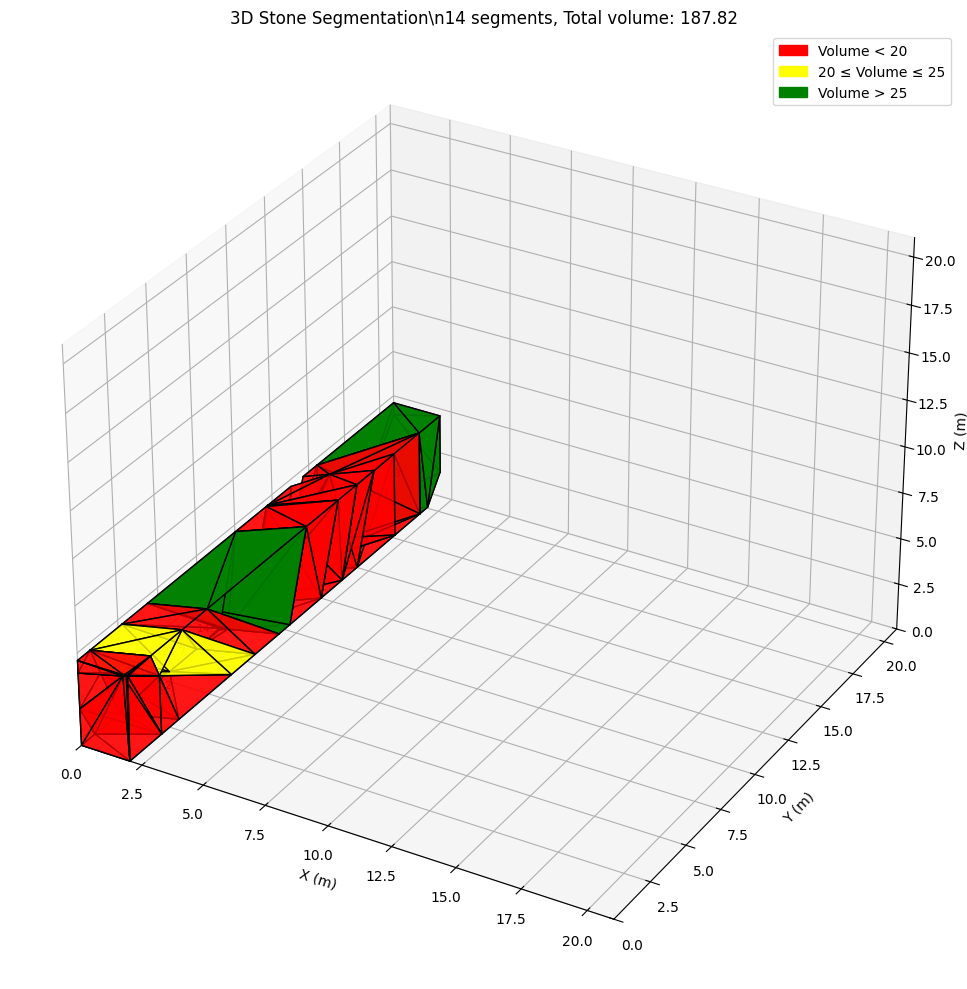

In [9]:
# Create 3D visualization using matplotlib
print("Creating 3D visualization...")
volumes_viz = stone.visualize()

## Alternative Trimesh Visualization

Use trimesh Scene for interactive 3D visualization.

In [10]:
# Create interactive 3D visualization using trimesh
print("Creating interactive trimesh visualization...")
# Note: This will open in a separate window
stone.visualize_trimesh()

Creating interactive trimesh visualization...
Starting slicing with 12 discontinuities...
Processing discontinuity 1/12
Processing discontinuity 2/12
Processing discontinuity 3/12
Processing discontinuity 4/12
Processing discontinuity 5/12
Processing discontinuity 6/12
Processing discontinuity 7/12
Processing discontinuity 8/12
Processing discontinuity 9/12
Processing discontinuity 10/12
Processing discontinuity 11/12
Processing discontinuity 12/12
Slicing complete. Generated 14 segments.


## Export Results

Export segment data to Excel for further analysis.

In [8]:
# Export segment data to Excel
output_file = 'segments.xlsx'
stone.export_segments_to_excel(output_file)

# Verify the exported data
print(f"\\nVerifying exported data...")
exported_df = pd.read_excel(output_file)
print(f"Exported data shape: {exported_df.shape}")
print("\\nFirst few rows of exported data:")
print(exported_df.head(10))

# Summary statistics
print(f"\\nExport Summary:")
print(f"Unique segments: {exported_df['Segment'].nunique()}")
print(f"Volume range: {exported_df['Volume'].min():.2f} - {exported_df['Volume'].max():.2f}")
print(f"Color distribution:")
print(exported_df['Color'].value_counts())

Starting slicing with 12 discontinuities...
Processing discontinuity 1/12
Processing discontinuity 2/12
Processing discontinuity 3/12
Processing discontinuity 4/12
Processing discontinuity 5/12
Processing discontinuity 6/12
Processing discontinuity 7/12
Processing discontinuity 8/12
Processing discontinuity 9/12
Processing discontinuity 10/12
Processing discontinuity 11/12
Processing discontinuity 12/12
Slicing complete. Generated 14 segments.
Segment data exported to: segments.xlsx
Total segments: 14
Total data points: 243
\nVerifying exported data...
Exported data shape: (243, 6)
\nFirst few rows of exported data:
   Segment     Volume  Color         X          Y         Z
0        0  29.611218  green  0.000000   4.346502  4.600000
1        0  29.611218  green  2.000000   9.639307  0.000000
2        0  29.611218  green  2.000000   9.222556  0.419958
3        0  29.611218  green  1.766229   9.554221  0.000000
4        0  29.611218  green  2.000000   5.074442  4.600000
5        0  29.6